In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa

In [19]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [20]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [21]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [22]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [23]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output

In [24]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

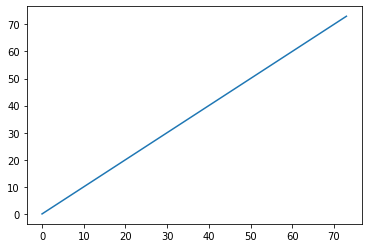

In [25]:
plt.plot(jamo_tokens)
plt.show()

In [26]:
embedding_layer = nn.Embedding(len(jamo_tokens), 256)

초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
초현실주의 회화는 어떤 사람에게는 색과 모양을 마구잡이로 섞어 놓은 것처럼 보일 수 있다.
104


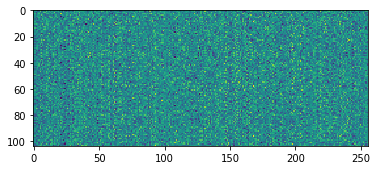

In [28]:
print(metadata[5031, 3])
print(metadata[5031, 2])
print(len(metadata[5031, 3]))

input_token = tokenizer.word2num(metadata[5031, 3])
input_tensor = torch.tensor(input_token)
plt.imshow(embedding_layer(input_tensor).detach().numpy())

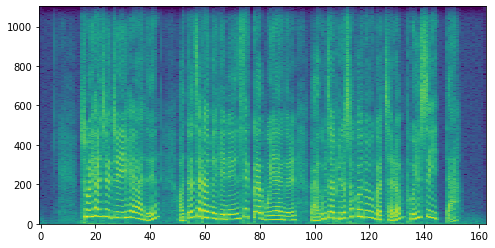

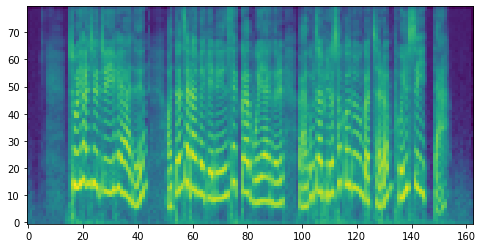

In [29]:
for i, wav_name in enumerate([wave_name_list[5031]]):
    wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
    y, sr = librosa.core.load(wav_path)
    
    f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

    Sxx = np.abs(Zxx)
    Sxx = np.maximum(Sxx, eps)

    # plt.figure(figsize=(20,20))
    # plt.imshow(20*np.log10(Sxx), origin='lower')
    # plt.colorbar()
    # plt.show()

    mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

    mel_specgram = np.matmul(mel_filters, Sxx)

    log_specgram = 20*np.log10(Sxx)

    norm_log_specgram = (log_specgram + db_ref) / db_ref

    log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

    norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
#     np.save(specgram_path, norm_log_specgram)
#     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
#     print(norm_log_mel_specgram.shape[1])

    if i % 1000 == 0:

        plt.figure(figsize=(8, 4))
        plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
#         plt.colorbar()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#         plt.colorbar()
        plt.show()    
    break

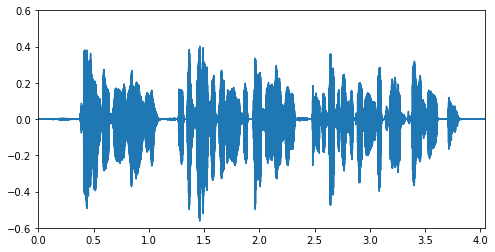

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, len(y)/fs, 1/fs), y)
plt.ylim([-.6, .6])
plt.xlim([0, len(y)/fs])
plt.show()

In [31]:
input_spectrogram = norm_log_mel_specgram.T
print(input_spectrogram.shape)

(163, 80)


In [36]:
input_tensor

tensor([21, 34, 25, 32, 50, 16, 46, 54, 19, 39, 18, 45,  0, 25, 37, 25, 35,  9,
        44, 50,  0, 18, 30, 11, 30, 50,  0, 16, 26, 12, 26, 62, 18, 31,  7, 31,
         9, 44, 50,  0, 16, 27, 47,  7, 35,  0, 13, 34, 18, 28, 67, 18, 44, 54,
         0, 13, 26,  7, 39, 19, 26, 63, 18, 46, 12, 34,  0, 16, 30, 48, 18, 30,
         0,  9, 34, 73, 18, 44, 50,  0,  7, 30, 65, 21, 30, 12, 30, 62,  0, 14,
        34, 18, 46, 54,  0, 16, 39,  0, 18, 46, 66, 10, 26,  3])

In [209]:
torch.autograd.set_detect_anomaly(True)

In [206]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        
        self.gru = nn.GRU(H, D_out, num_layers=3, bidirectional=True)
        self.relu_gru = torch.nn.ReLU()

    def forward(self, input_tensor):
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.gru = nn.GRU(2 * H, H)
        self.attention = AttentionModule(D_out * 2)
        self.fc = nn.Linear(1024, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query):
        output_tensor = self.fc_embed(input_tensor)
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        context_vector = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))
        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor

class AttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose_(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector

class Mel2SeqNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        self.H = H
        self.encoder = Encoder(D_in, H, D_out) 
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256)
        self.decoder = Decoder(H, D_out)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_tensor, ground_truth):

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, 1, self.H)
        
        pred_tensor_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>']))).view([1, 1, -1])
        
        for i in range(len(ground_truth)):
            
            pred_tensor, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoded_tensor)
            pred_tensor_list.append(pred_tensor)
            
            loss += self.criterion(pred_tensor.view([1, -1]), ground_truth[i].view(1))
#             print(loss)
            decoder_input = self.embedding_layer(ground_truth[i]).view([1, 1, -1])
            
        pred_tensor = torch.cat(pred_tensor_list, dim=1)
        
        return pred_tensor, loss
    
net = Mel2SeqNet(80, 512, 256)

In [210]:
tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])

ground_truth = torch.tensor(tokenizer.word2num(list(metadata[5031, 3]) + ['<eos>']))

pred_tensor, loss = net(tensor_input, ground_truth)

loss.backward()

..\torch\csrc\autograd\python_anomaly_mode.cpp:57: UserWarning: Traceback of forward call that caused the error:
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\tornado\platform\asyncio.py

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 163, 1]], which is output 0 of SoftmaxBackward, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [197]:
loss

tensor(451.9157, grad_fn=<AddBackward0>)

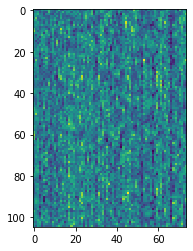

In [194]:
plt.imshow(pred_tensor.detach().numpy()[0])

In [44]:
torch.cat([torch.tensor([[1, 2, 3], [1, 2, 3]]), torch.tensor([[1, 2, 3], [1, 2, 3]])], 1).shape

torch.Size([2, 6])

In [51]:
_, index = tensor_input.max(-1)
print(index.view(-1))
sentence = tokenizer.decode(index.view(-1))
print(sentence)

tensor([ 1,  4,  0,  1,  1,  0,  1, 23, 51, 23,  8, 11,  9,  8,  1, 63, 14, 14,
        13, 14, 16, 14, 14, 14, 15, 13, 12, 12, 12, 11, 11, 12, 12, 13, 23, 30,
        10,  9,  7,  6,  7,  9, 11, 14, 49,  6,  4, 48, 47, 25,  8,  6,  6,  6,
        23, 23, 13, 15, 15, 26, 25, 24, 11, 22, 10,  9, 19, 18,  8,  9, 19, 19,
        10, 10, 15, 15, 14,  0, 24, 23, 22,  9,  8, 16, 16, 17, 25, 24,  8,  7,
        22,  7,  7,  8,  6, 50, 48, 34,  0,  7,  6,  6,  6, 10, 10, 12, 23, 22,
        10, 10, 10, 22, 11, 14, 15, 14, 14, 14, 13, 13, 12, 11, 10, 18, 24,  7,
        69,  7,  6, 21,  7, 10, 13, 13,  4,  9, 19, 10, 12, 13, 71, 14, 13, 12,
        11,  9,  0,  0, 11, 30,  8,  6,  7, 10,  0,  0,  0,  0,  0,  0,  0,  7,
         0])
['!', '<eos>', ' ', '!', '!', ' ', '!', 'ᄐ', 'ᆬ', 'ᄐ', 'ᄁ', 'ᄄ', 'ᄂ', 'ᄁ', '!', 'ᆸ', 'ᄇ', 'ᄇ', 'ᄆ', 'ᄇ', 'ᄉ', 'ᄇ', 'ᄇ', 'ᄇ', 'ᄈ', 'ᄆ', 'ᄅ', 'ᄅ', 'ᄅ', 'ᄄ', 'ᄄ', 'ᄅ', 'ᄅ', 'ᄆ', 'ᄐ', 'ᅥ', 'ᄃ', 'ᄂ', 'ᄀ', '?', 'ᄀ', 'ᄂ', 'ᄄ', 'ᄇ', 'ᆪ', '?', '<eos>', 'ᆩ', 'ᆨ', 'ᄒ', 'ᄁ', '?'